In [558]:
# Estos dos comandos evitan que haya que hacer reload cada vez que se modifica un paquete
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [559]:
# https://github.com/matplotlib/jupyter-matplotlib
# jupyter nbextension enable --py --sys-prefix widgetsnbextension

In [582]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from collections import Counter


In [583]:
data = pd.read_csv('data/alturas-pesos-mils-train.csv')[:2000]

In [584]:
from sklearn.preprocessing import MinMaxScaler
normalizeData = MinMaxScaler()
X_train  = normalizeData.fit_transform(data[['Peso', 'Altura']].values)

In [585]:
data_hombres = normalizeData.transform(data.loc[data['Genero']=='Hombre'][['Peso','Altura']].values)
data_mujeres = normalizeData.transform(data.loc[data['Genero']=='Mujer'][['Peso','Altura']].values)

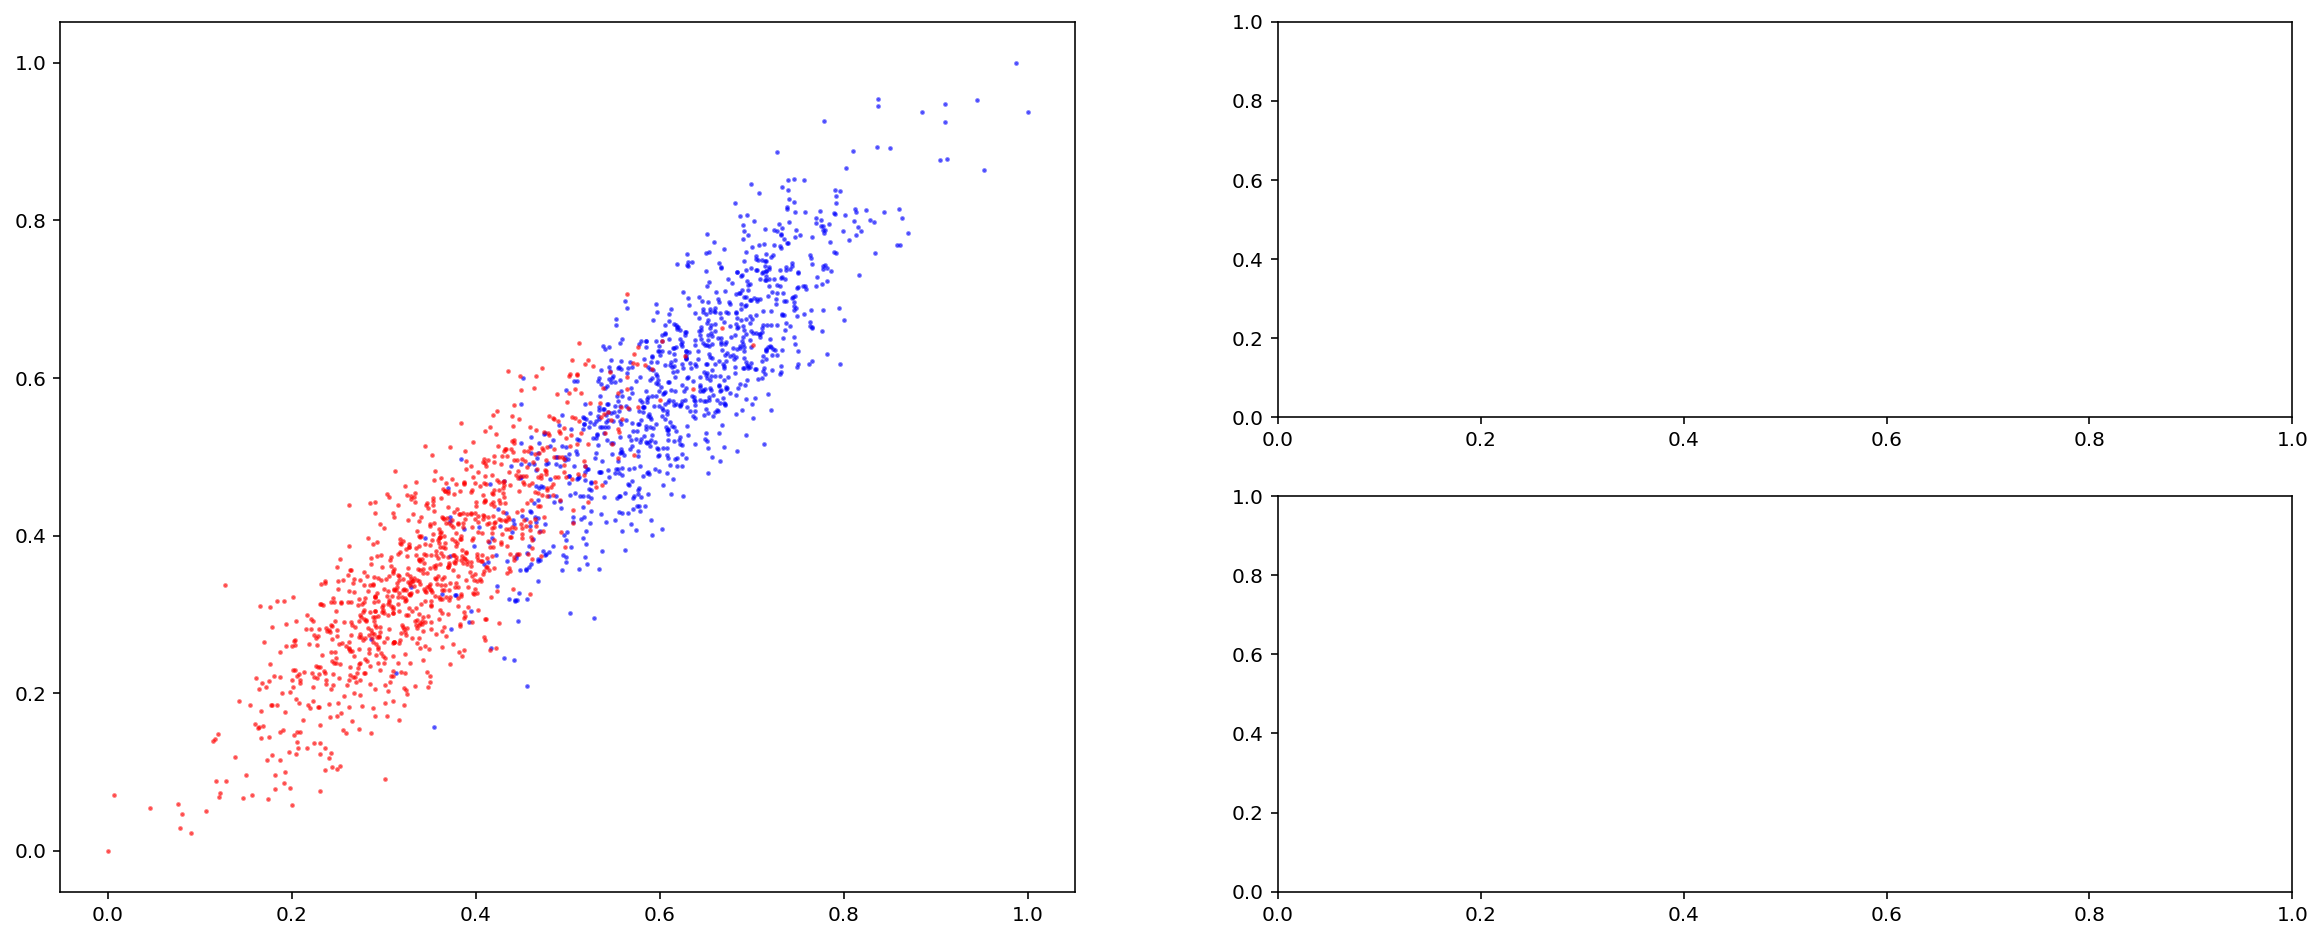

In [586]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(20,8))

gs=GridSpec(2,2) # 2 rows, 3 columns

ax=fig.add_subplot(gs[:,0]) # Second row, span all columns
axLoss=fig.add_subplot(gs[0,1]) # First row, first column
axAcc=fig.add_subplot(gs[1,1]) # First row, second column


#fig, ((ax, axLoss), (axAcc, ax2) )= plt.subplots(2,2, figsize=(20,10))
ax.scatter(data_hombres[:,0], data_hombres[:,1], color='b', s=2, alpha=0.5)
ax.scatter(data_mujeres[:,0], data_mujeres[:,1], color='r', s=2, alpha=0.5)

In [587]:
labels = data['Genero'].values.copy()
labels[labels=='Hombre'] = 0
labels[labels=='Mujer'] = 1

In [588]:
data[['Peso', 'Altura']].values.mean(axis=0)

array([ 72.7281345, 168.0861685])

In [589]:
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam, SGD

In [590]:
import math
def nCr(n,r):
    f = math.factorial
    return int(f(n) / f(r) / f(n-r))

def get_polynimial_set(X, degree = 12, bias = False):
    # Recibe el dataset X de numero_de_muestras x features  y devuelve una matriz con todas las combinaciones 
    # De los productos del grado indicado en degree
    k = 2
    n = degree + k
    pos = 0
    X_mat = np.zeros((X.shape[0],nCr(n,k)))
    for i in range(degree + 1):
        for j in range(i+1):
            X_mat[:,pos] = (X[:,0]**(i-j))*X[:,1]**j
            pos = pos + 1
    if bias:
        return X_mat
    else:
        return X_mat[:,1:]

In [591]:
import keras
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

class PlotBoundary(keras.callbacks.Callback):
    def plotBoundary(self):
        clear_output(wait=True)
        fig=plt.figure(figsize=(20,8))
        gs=GridSpec(2,2) # 2 rows, 3 columns
        ax=fig.add_subplot(gs[:,0]) # Second row, span all columns
        axLoss=fig.add_subplot(gs[0,1]) # First row, first column
        axAcc=fig.add_subplot(gs[1,1]) # First row, second column
        #self.fig, (self.ax, self.axLoss, self.axAcc )= plt.subplots(1,3, figsize=(20,4))
        ax.scatter(data_hombres[:,0], data_hombres[:,1], color='b', s=2, alpha=0.5)
        ax.scatter(data_mujeres[:,0], data_mujeres[:,1], color='r', s=2, alpha=0.5)
        Z = 1 - self.model.predict_proba(get_polynimial_set(np.c_[self.X.flatten(), self.Y.flatten()], self.degree))[:, 0]
        Z = Z.reshape(self.Z_shape)
        ax.contour(self.X, self.Y, Z, (0.5,), colors='k', linewidths=0.5)
        axAcc.plot(self.acc)
        axLoss.plot(self.loss)
        #self.fig.canvas.draw()
        plt.show()
        
        
    def __init__(self, data, degree=1, plots_every_batches=100, N = 300):
        self.plots_every_batches = plots_every_batches
        self.N = N
        self.degree = degree
        mins = data[:,:2].min(axis=0)
        maxs = data[:,:2].max(axis=0)
        X_lin = np.linspace(mins[0], maxs[0], self.N)
        Y_lin = np.linspace(mins[1], maxs[1], self.N)
        self.X, self.Y = np.meshgrid(X_lin, Y_lin)
        self.Z_shape = self.X.shape
        self.acc = []
        self.loss = []
        #ax.set_ylabel('Alturas [cms]')
        #ax.set_xlabel('Pesos [kgs]')
        #plt.colorbar(cf, ax=ax)
        
    def on_train_begin(self, logs={}):
        self.plotBoundary()
        return
    
    def on_epoch_end(self, epoch, logs={}):
        return
    
    def on_batch_end(self, batch, logs={}):
        if batch%self.plots_every_batches == 0:
            self.acc.append(logs.get('acc'))
            self.loss.append(logs.get('loss'))
            self.plotBoundary()
        return

In [592]:
degree=2
X_train_pol = get_polynimial_set(X_train, degree=degree, bias=False)

In [598]:
model = Sequential()
model.add(Dense(1, input_dim=X_train_pol.shape[1], activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 1)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


In [599]:
# Lineal: Adam lr=5 se ve inercia (len_data=500)
# Grado 10: Adam lr=1, luego de 5000 epochs oscila (len_data=50), se baja a lr=0.1 converge
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=5), metrics=['accuracy'])

In [600]:
batch_size = int(len(X_train_pol)/1)

In [601]:
plot_boundary = PlotBoundary(X_train_pol, degree, N=100, plots_every_batches=int(len(X_train_pol)/batch_size))
history = model.fit(X_train_pol, labels, epochs=10000, batch_size=batch_size, 
                      verbose=0, callbacks=[plot_boundary])

In [ ]:
filename='adam-lr-5-200'

In [178]:
np.save('history-'+filename,history.history)
model.save_weights('weights-'+filename)

In [602]:
mins = X_train.min(axis=0)
maxs = X_train.max(axis=0)

In [603]:
from sklearn.linear_model import LogisticRegression
log_Reg = LogisticRegression(C=1000)
log_Reg.fit(X_train, data['Genero'])

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [604]:
log_Reg.score(X_train, data['Genero'])

0.9175

In [607]:
model.evaluate(get_polynimial_set(X_train, degree), labels)

2000/2000 [==============================] - 1s 387us/step


[0.2061598238348961, 0.9165]

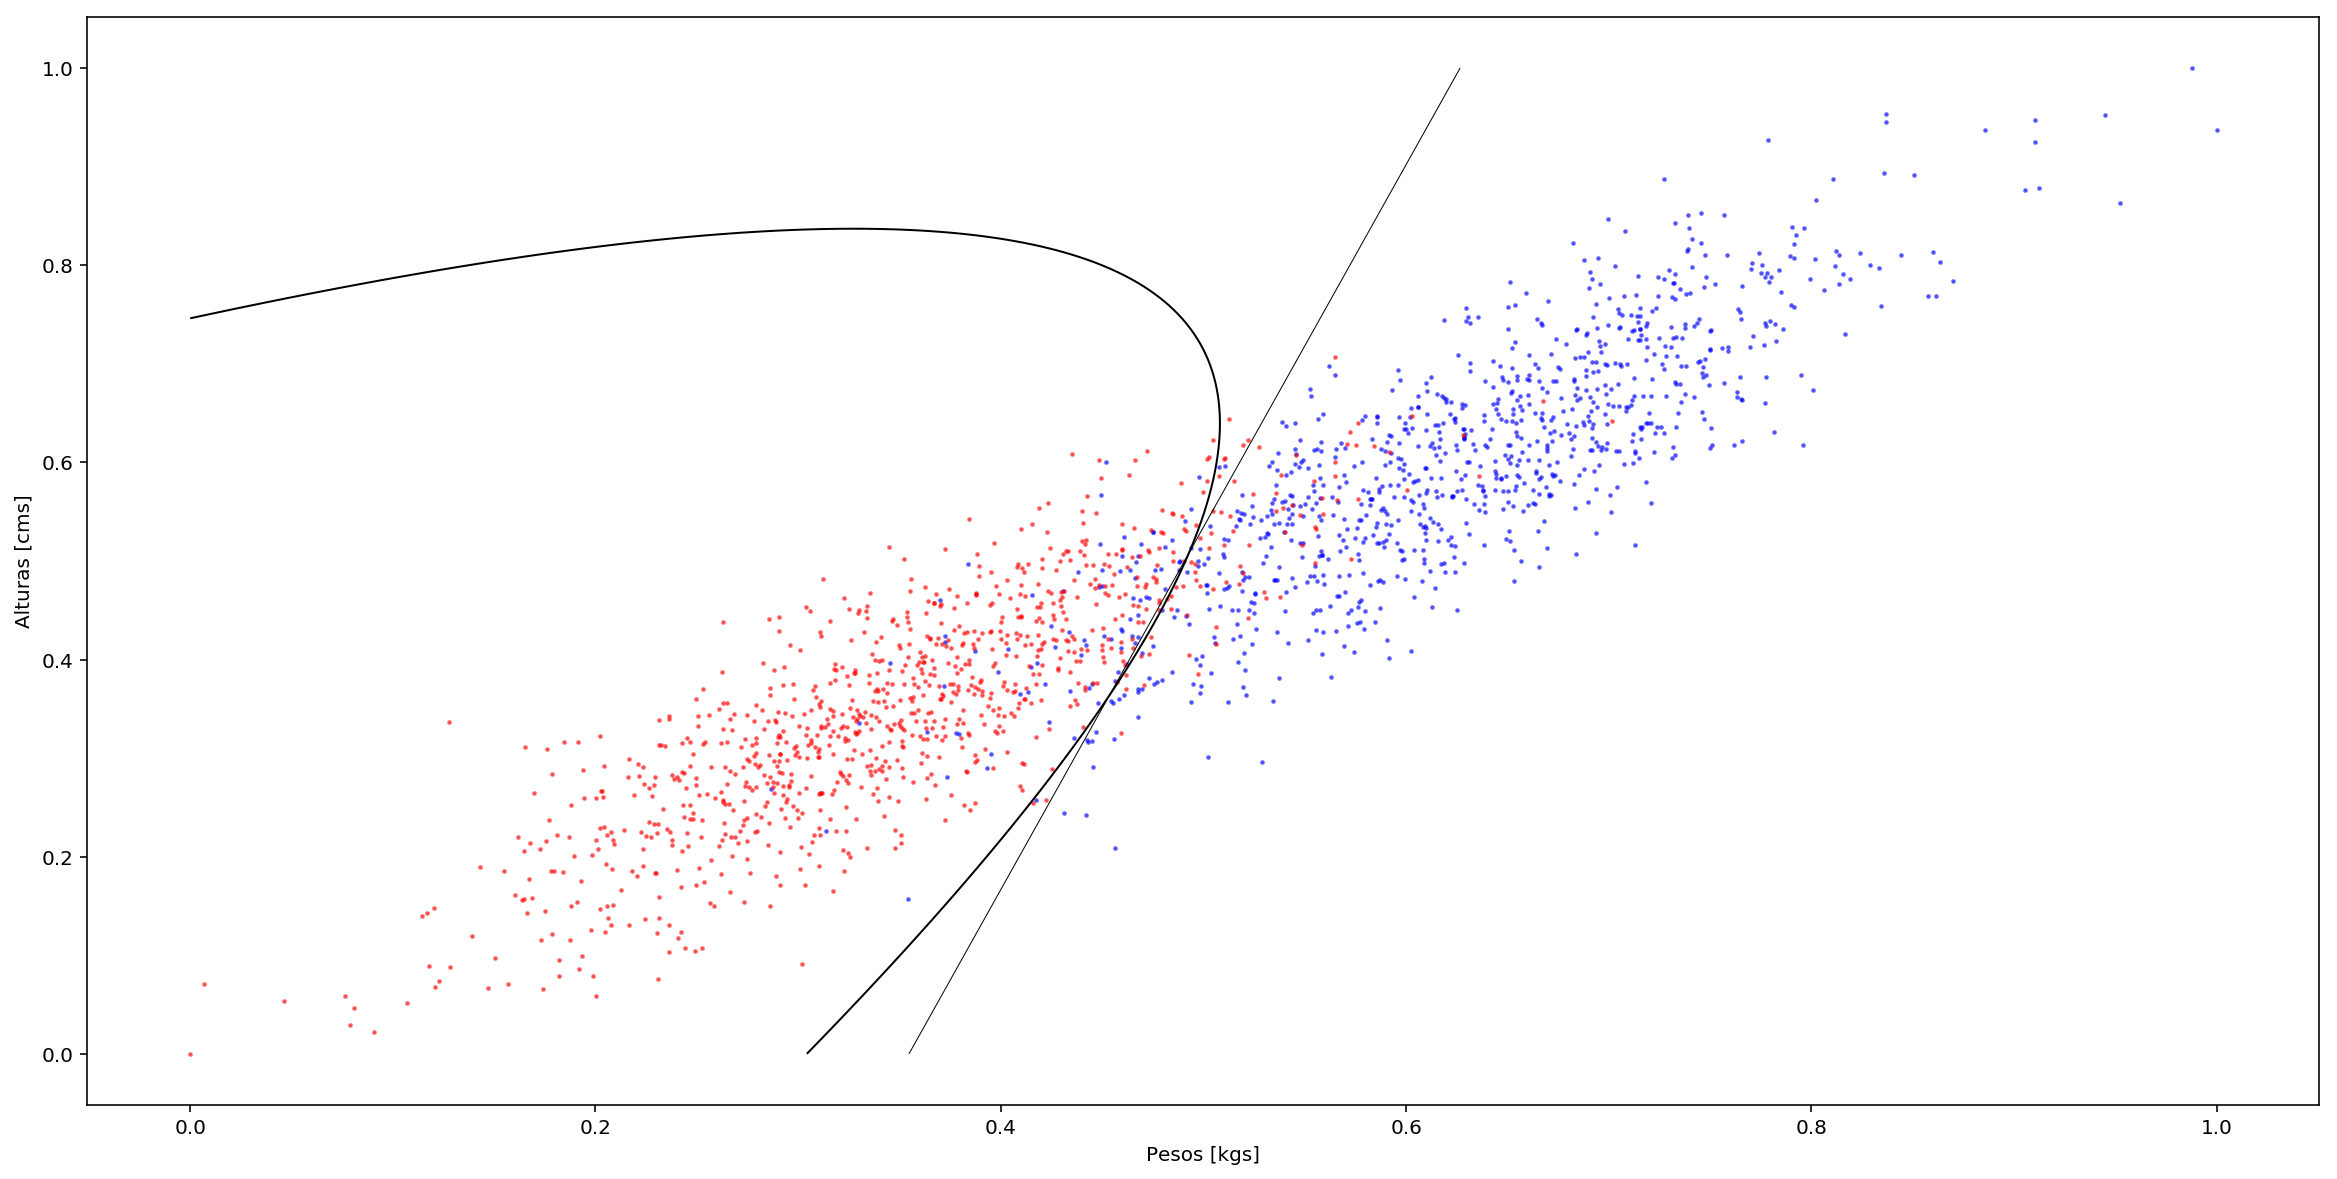

In [608]:
%matplotlib inline
N = 300
X = np.linspace(mins[0], maxs[0], N)
Y = np.linspace(mins[1], maxs[1], N)
X, Y = np.meshgrid(X, Y)

Z_nn = model.predict_proba(get_polynimial_set(np.c_[X.flatten(), Y.flatten()], degree))[:, 0]
Z_lr = log_Reg.predict_proba(np.c_[X.flatten(), Y.flatten()])[:, 0]

# Put the result into a color plot
Z_lr = Z_lr.reshape(X.shape)
Z_nn = Z_nn.reshape(X.shape)

fig = plt.figure(figsize=(20,10))
ax = fig.gca()
cm = plt.cm.RdBu
#cf = ax.contourf(X, Y, Z_lr, 256, alpha=.5, vmin=0., vmax=1., cmap=cm)
ax.contour(X, Y, Z_lr, (0.5,), colors='k', linewidths=0.5)
ax.contour(X, Y, Z_nn, (0.5,), colors='k', linewidths=1)
ax.scatter(data_hombres[:,0], data_hombres[:,1], color='b', s=2, alpha=0.5)
ax.scatter(data_mujeres[:,0], data_mujeres[:,1], color='r', s=2, alpha=0.5)
ax.set_ylabel('Alturas [cms]')
ax.set_xlabel('Pesos [kgs]')
#plt.colorbar(cf, ax=ax)
plt.show()